In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from scipy import stats 
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import optuna
import pickle
import warnings
warnings.simplefilter('ignore')

## 1. Постановка задачи
Разработать сервис для предсказания стоимости домов на основе истории предложений.

## 2. Знакомство с данными + EDA

In [2]:
df = pd.read_csv("data/data.csv")
print(df.shape)
df.head(1)

(377185, 18)


,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"


In [11]:
def subplots(data, feature):
    """Функция для построения столбчатой диаграмы
    для визуализации зависимости признака от target

    Args:
        data: Исходный датафрейм
        feature: Имя признака для анализа
        target: Целевой признак

    Returns:
        Выводит график
    """
    group = data.groupby(feature)['target'].median().sort_values(ascending=False)

    fig, ax = plt.subplots(figsize=(6, 3))
    sns.barplot(x=group.index, y=group.values)
    plt.title(f'Медианная стоимость в зависимости от {feature}', size= 12)
    ax.xaxis.set_tick_params(rotation=45)
    plt.ylabel('target');    

## target - стоимость недвижимости

In [4]:
# используем регулярное выражение для нахождения чисел
df['target'] = df['target'].str.extract(r'(\d{1,3}(?:,\d{3})*)') 
df['target'] = df['target'].str.replace(',', '')
# удаляем пропуски
df = df[df['target'].notnull()]
# переводим в числовой формат 
df['target'] = df['target'].astype(int)

## sqft - площадь объекта недвижимости

In [5]:
# С помощью регулярного выражения выделим площадь из строки
df['sq_m'] = df['sqft'].str.extract(r'(\d{1,9}(?:,\d{3})*)') 
df['sq_m'] = df['sq_m'].str.replace(',', '')

# удаляем пропуски
df = df[df['sq_m'].notnull()]

# переводим в числовой формат и далее переводим из футов в метры (для наглядности)
df['sq_m'] = (df['sq_m'].astype(int) * 0.0929).round(1) 

# Удаление признака «sqft»
df.drop(['sqft'], axis=1, inplace=True)

# Удалим недвижимость с площадью равной 0
df = df[df.sq_m > 0]

## status - статус продажи

Объединим все статусы продаж в 5 групп

In [7]:
# 1. Новостройки
new = ['New construction', 'New']
# 2. Продажа недвижимости с аукциона
auction = ['foreclosure', 'Pre-foreclosure', 'Pre-foreclosure / auction', 'Auction', 'Foreclosed', 'Foreclosure', 
           'Auction - Active', 'Active - Auction', 'Contingent   Foreclosure']
# 3. Недвижимость продается
for_sale = ['Active', 'A Active', 'for sale', 'For sale', 'Back on Market', 'Active With Offer', 'Active Backup', 
          'Listing Extended', 'Contingent Escape', 'Active Option', 'Back On Market']
# 4. Все данные с пропусками
# 5. Все остальные будут в группе 'contract', т.е. на продажу уже заключен контракт

# Есть еще одна группа - это аренда недвижимости, но её удалим, т.к. здесь рассматриваем только продажу
rent = ['for rent', 'Condo for rent', 'Apartment for rent']
df = df[~df.status.isin(rent)]  # ~ возвращены строки, не соответствующие условию

In [8]:
def status(arg: str) -> str:
    """Функция преобразования признака «status»

    Args:
        arg (str): Строка из признака «status»

    Returns:
        str: Cтатус продажи
    """
    if arg in new:
        arg = 'new'
    elif arg in auction:
        arg = 'auction'
    elif arg in for_sale: 
        arg = 'for sale'
    elif arg is np.nan:
        arg = 'no_data'
    else:
        arg = 'contract'
        
    return arg

df['status'] = df['status'].apply(status)

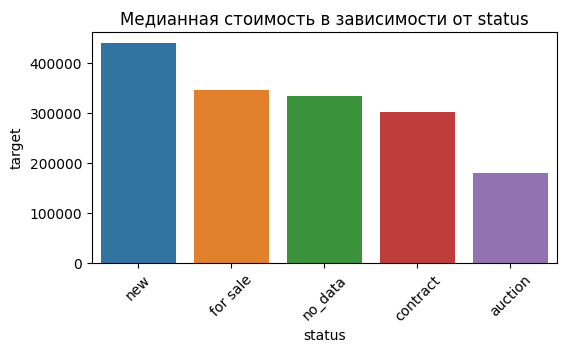

In [9]:
# Распределение признака в зависимости от медианной стоимости
subplots(df,'status') 

Как видно из графика стоимость недвижимости зависит от статуса продаж.

## private pool и PrivatePool - наличие частного бассейна

In [12]:
# Объединим два признака с бассейнами в один, заменив наличие бассейна на 1, отсутствие - на 0.
df['pool_1'] = df['PrivatePool'].apply(lambda x: 1 if x == 'yes' or x == 'Yes' else 0)
df['pool_2'] = df['private pool'].apply(lambda x: 1 if x == 'Yes' else 0)
df['pool'] = df['pool_1'] + df['pool_2']

# Удаление использованных признаков
df.drop(['PrivatePool', 'private pool', 'pool_1', 'pool_2'], axis=1, inplace=True)

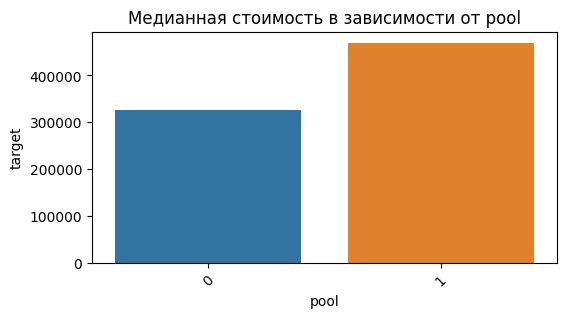

In [13]:
# Распределение признака в зависимости от медианной стоимости
subplots(df,'pool')

Как видно из графика стоимость недвижимости зависит от наличия бассейна.

## propertyType - тип недвижимости

#### Объединим типы недвижимости в группы

In [14]:
# Переведем названия в нижний регистр, т.к. один и тот же тип недвижимости может быть записн большими и маленькими буквами
df['propertyType'] = df['propertyType'].str.lower()

def property_type(arg: str) -> str:
    """Функция преобразования признака «propertyType».
        Объединяем недвижимость в группы в зависимости от типа недвижимости

    Args:
        arg (str): Строка из признака «propertyType»

    Returns:
        str: Тип недвижимости
    """
    if 'condo' in str(arg) or 'low' in str(arg):  
        arg = 'condominium'
    elif 'town' in str(arg) or 'cluster' in str(arg) or 'attach' in str(arg):
        arg = 'townhouse'
    elif 'coop' in str(arg) or 'co-op' in str(arg):
        arg = 'cooperative'
    elif 'apart' in str(arg) or 'garden apartment' in str(arg):
        arg = 'apartment' 
    elif 'mob' in str(arg) or 'mfd' in str(arg) or 'manuf' in str(arg):
        arg = 'mobile_home' 
    elif 'pent' in str(arg) or 'high' in str(arg):
        arg = 'penthouse' 
    elif 'land' in str(arg) or 'lot' in str(arg):
        arg = 'land'
    elif arg is np.nan:
        arg = 'no_data'    
    else:
        arg = 'house'
       
    return arg

df['propertyType'] = df['propertyType'].apply(property_type)

# Удалим тип недвижимости 'land', т.к. это пустой участок без дома.
df = df[df.propertyType != 'land']

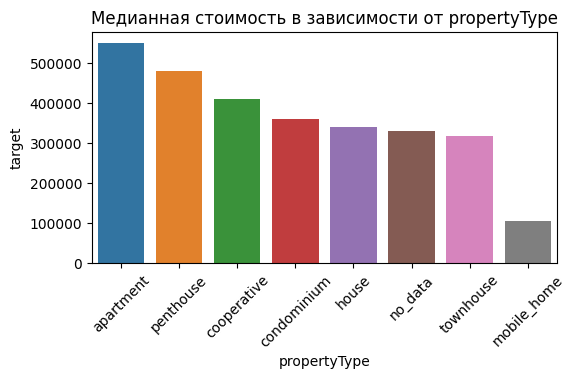

In [15]:
# Распределение признака в зависимости от медианной стоимости
subplots(df,'propertyType')

Как видно из графика стоимость недвижимости зависит от типа недвижимости.

## schools - сведения о школах в районе

In [16]:
def deserialize_rating(serialized_string: str) -> str:
    """Функция для десериализации строки в список словарей,
       вывода рейтинга школ, находящихся в районе, из словаря 
       и определения среднего рейтинга школ.

    Args:
        serialized_string (str): Строка из признака «schools»

    Returns:
        str: Cредний рейтинг школ в районе
    """
    # десериализуем строку в список словарей и выведем рейтинг школ из словаря
    rating = ast.literal_eval(serialized_string)[0]['rating']  
    # Список для хранения значений рейтига по каждой школе
    rating_numbers = []

    for item in rating:
        list = item.split('/')
        # Проверяем, является ли первый элемент числом (в списке м.б. один или два элемента)
        if list[0].isdigit():
            rating_numbers.append(int(list[0]))
    # Вычисляем среднее арифметическое 
    average = round(np.mean(rating_numbers), 2)
     
    return average

df['schools_rating_avg'] = df['schools'].apply(deserialize_rating)

# Удаление строк, где отсутствует рейтинг 
df = df[df['schools_rating_avg'].notnull()]

In [17]:
def deserialize_distance(serialized_string: str) -> str:
    """Функция для десериализации строки в список словарей,
       вывода расстояния до школ, находящихся в районе, из словаря 
       и определения среднего расстояния до школ.

    Args:
        serialized_string (str): Строка из признака «schools»

    Returns:
        str: Cреднее расстояние до школ в районе
    """
    # десериализуем строку в список словарей и выведем расстояния до школ из словаря
    distance = ast.literal_eval(serialized_string)[0]['data']['Distance']     
    # Список для хранения значений расстояний от дома до школ
    distance_numbers = []

    for item in distance:
        item = item.replace('mi', '')
        distance_numbers.append(float(item))
    # Вычисляем среднее арифметическое 
    average = round(np.mean(distance_numbers), 2)
     
    return average

df['schools_distance_avg'] = df['schools'].apply(deserialize_distance)

# Оставляем строки, где расстояние менее 10 км
df = df[df['schools_distance_avg'] < 10]

# Удаление использованного признака
df = df.drop('schools', axis=1)

In [19]:
def schools_distance(arg: str) -> str:
    """Функция преобразования признака «schools_distance_avg».
        Объединяем недвижимость в группы в зависимости от среднего 
        расстояния до школ. 

    Args:
        arg (str): Строка из признака «schools_distance_avg»

    Returns:
        str: Наименование группы в зависимости от среднего расстояния до школ.
    """
    if arg < 0.5: arg = 'до 0.5'
    elif 0.5 <= arg < 1: arg = '0.5-1'
    elif 1 <= arg < 2: arg = '1-2'
    elif 2 <= arg < 3: arg = '2-3'
    elif 3 <= arg < 4: arg = '3-4'
    elif 4 <= arg < 5: arg = '4-5'
    elif 5 <= arg < 10: arg = '5-10'
    else:
        arg = 'no_data'
        
    return arg

df['schools_distance_avg'] = df['schools_distance_avg'].apply(schools_distance)

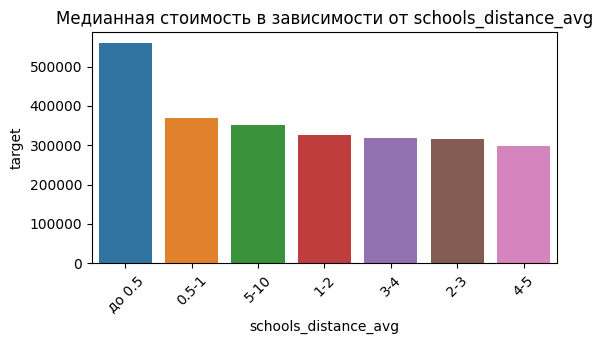

In [20]:
# Распределение признака в зависимости от медианной стоимости
subplots(df,'schools_distance_avg')

Как видно из графика нет такой зависимости, что чем больше расстояние, тем меньше цена. Стоимость недвижимости, скорее всего, не зависит от среднего расстояния до школ.

## mls-id и MlsId - идентификатор MLS

In [21]:
# Объединим два признака с MLS в один, заменив наличие MLS на 1, отсутствие - на 0.
df['mls-id'] = df['mls-id'].apply(lambda x: 0 if x is np.nan else 1)
df['MlsId'] = df['MlsId'].apply(lambda x: 0 if x is np.nan else 1)
df['mls_id'] = df['mls-id'] + df['MlsId']

# Удаление использованных признаков
df.drop(['mls-id', 'MlsId'], axis=1, inplace=True)

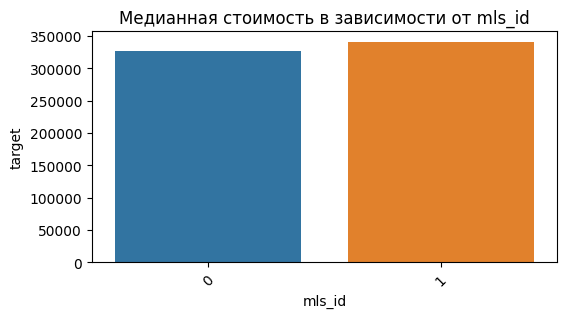

In [22]:
# Распределение признака в зависимости от медианной стоимости
subplots(df,'mls_id')

Как видно из графика стоимость недвижимости почти не зависит от наличия MLS. Вклад данного признака в определении стоимости будет незначительным.

## homeFacts

### Создаем признак 'year_built'

In [23]:
# десериализуем строки в список словарей и выведем год постройки объекта недвижимости из словаря
df['year_built'] = df['homeFacts'].apply(lambda x: ast.literal_eval(x)['atAGlanceFacts'][0]['factValue'])
# избавимся от всех не числовых символов (они будут NaN)
regex = '\d{4}'
df['year_built'] = df['year_built'].str.findall(regex).str.get(0)
# Пропуски оставим (потом отправим их в 'no_data'), остальное в int
df['year_built'] = df['year_built'].apply(lambda x: x if pd.isna(x) else int(x)) 

In [24]:
def year_built(arg: str) -> str:
    """Функция преобразования признака «year_built».
        Объединяем недвижимость в группы в зависимости от года постройки

    Args:
        arg (str): Строка из признака «year_built»

    Returns:
        str: Наименование группы в зависимости от года постройки
    """
    if arg >= 2019: arg = '2019-2022'
    elif 2010 <= arg < 2019: arg = '2010-2018'
    elif 2000 <= arg < 2010: arg = '2000-2009'
    elif 1990 <= arg < 2000: arg = '1990-1999'
    elif 1980 <= arg < 1990: arg = '1980-1989'
    elif 1970 <= arg < 1980: arg = '1970-1979'
    elif 1940 <= arg < 1970: arg = '1940-1969'
    elif 1930 <= arg < 1940: arg = '1930-1939'
    elif 1920 <= arg < 1930: arg = '1920-1929'
    elif 1910 <= arg < 1920: arg = '1910-1919'
    elif 1900 <= arg < 1910: arg = '1900-1909'
    elif arg < 1900: arg = 'до 1900'
    else:
        arg = 'no_data'
        
    return arg

df['year_built'] = df['year_built'].apply(year_built)

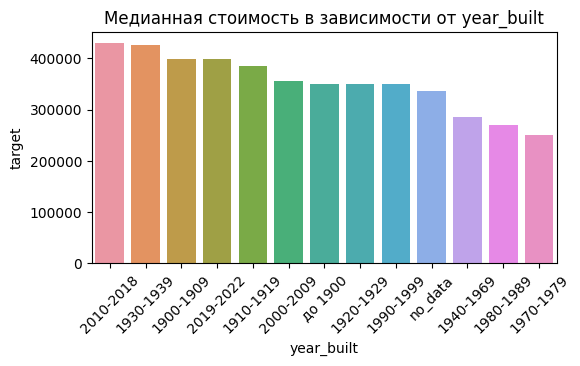

In [26]:
# Распределение признака в зависимости от медианной стоимости
subplots(df,'year_built')

Как видно из графика стоимость недвижимости зависит от года постройки.

### Создаем признак 'heating'

In [27]:
# десериализуем строки в список словарей и выведем тип отопления объекта недвижимости из словаря
df['heating'] = df['homeFacts'].apply(lambda x: ast.literal_eval(x)['atAGlanceFacts'][2]['factValue'])
# Переведем названия в нижний регистр, т.к. один и тот же тип отопления может быть записн большими и маленькими буквами
df['heating'] = df['heating'].str.lower()
# Удалим строки с пропусками (здесь их мало)
df = df[df['heating'].notnull()]

#### Объединим типы отопления в группы

In [31]:
def heating(arg: str) -> str:
    """Функция преобразования признака «heating».
        Объединяем в группы по типу отопления

    Args:
        arg (str): Строка из признака «heating»

    Returns:
        str: Тип отопления
    """
    if 'heat pump' in str(arg):  
        arg = 'heat_pump'
    elif 'electric' in str(arg):
        arg = 'electric'
    elif 'gas' in str(arg) or ', gas' in str(arg) or 'natural gas' in str(arg) or 'forced' in str(arg):
        arg = 'forced_air'
    elif 'central' in str(arg):
        arg = 'central' 
    elif 'no' in str(arg) or arg == '':
        arg = 'no_data'      
    else:
        arg = 'other'
       
    return arg

df['heating'] = df['heating'].apply(heating)

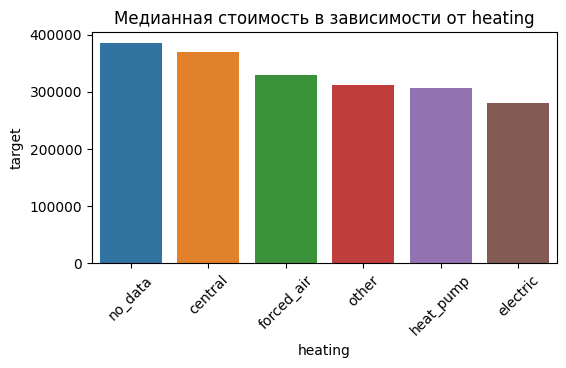

In [32]:
# Распределение признака в зависимости от медианной стоимости
subplots(df,'heating')

Как видно из графика стоимость недвижимости зависит от типа отопления.

### Создаем признак 'cooling'

In [33]:
# десериализуем строки в список словарей и выведем тип кондинционирования недвижимости из словаря
df['cooling'] = df['homeFacts'].apply(lambda x: ast.literal_eval(x)['atAGlanceFacts'][3]['factValue'])
# Переведем названия в нижний регистр, т.к. один и тот же вид оборудования может быть записн большими и маленькими буквами
df['cooling'] = df['cooling'].str.lower()

#### Объединим типы кондинционирования в группы

In [37]:
def cooling(arg: str) -> str:
    """Функция преобразования признака «cooling».
        Объединяем в группы по типу кондинционирования

    Args:
        arg (str): Строка из признака «cooling»

    Returns:
        str: Тип кондинционирования
    """
    if 'no' in str(arg) or arg == '':  
        arg = 'no_data'
    elif 'gas' in str(arg) or ', gas' in str(arg) or 'natural gas' in str(arg) or 'central' in str(arg):
        arg = 'central'     
    else:
        arg = 'other'
       
    return arg

df['cooling'] = df['cooling'].apply(cooling)

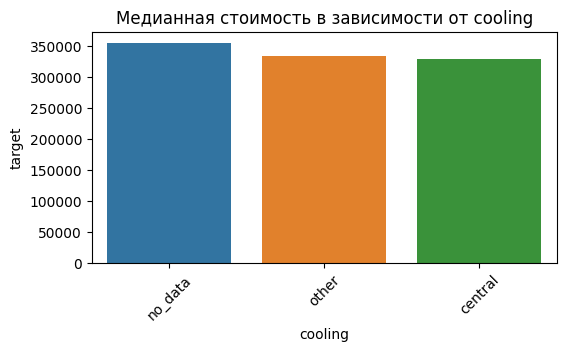

In [38]:
# Распределение признака в зависимости от медианной стоимости
subplots(df,'cooling')

Как видно из графика стоимость недвижимости мало зависит от типа кондинционирования. Вклад данного признака в определении стоимости будет незначительным.

### Создаем признак 'remodeled_year'

In [39]:
# десериализуем строки в список словарей и выведем год перестройки недвижимости из словаря
df['remodeled_year'] = df['homeFacts'].apply(lambda x: ast.literal_eval(x)['atAGlanceFacts'][1]['factValue'])
# избавимся от всех не числовых символов (они будут NaN)
regex = '\d{4}'
df['remodeled_year'] = df['remodeled_year'].str.findall(regex).str.get(0)
# Пропуски оставим (потом отправим их в 'no_data', остальное в int)
df['remodeled_year'] = df['remodeled_year'].apply(lambda x: x if pd.isna(x) else int(x))

In [40]:
def remodeled_year(arg: str) -> str:
    """Функция преобразования и создания признака «remodeled_year».
        Объединяем недвижимость в группы в зависимости от года перестройки

    Args:
        arg (str): Строка из признака «remodeled_year»

    Returns:
        str: Наименование группы в зависимости от года перестройки
    """
    if arg >= 2019: arg = '2019-2022' 
    elif 2010 <= arg < 2019: arg = '2010-2018'
    elif 2000 <= arg < 2010: arg = '2000-2009'
    elif 1990 <= arg < 2000: arg = '1990-1999'
    elif 1980 <= arg < 1990: arg = '1980-1989'
    elif 1970 <= arg < 1980: arg = '1970-1979'
    elif 1960 <= arg < 1970: arg = '1960-1969' 
    elif 1950 <= arg < 1960: arg = '1950-1959' 
    elif 1940 <= arg < 1950: arg = '1940-1949' 
    elif 1930 <= arg < 1940: arg = '1930-1939'
    elif 1920 <= arg < 1930: arg = '1920-1929'
    elif 1910 <= arg < 1920: arg = '1910-1919'
    elif 1900 <= arg < 1910: arg = '1900-1909'
    elif arg < 1900: arg = 'до 1900'
    else:
        arg = 'no_data'
        
    return arg

df['remodeled_year'] = df['remodeled_year'].apply(remodeled_year)

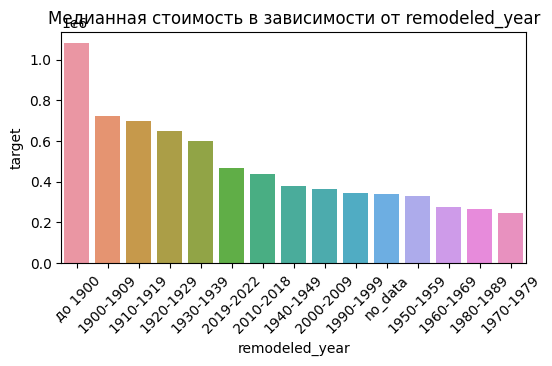

In [41]:
# Распределение признака в зависимости от медианной стоимости
subplots(df,'remodeled_year')

Как видно из графика стоимость недвижимости зависит от года перестройки.

### Создаем признак 'lotsize'

In [42]:
# десериализуем строки в список словарей и выведем признак lotsize из словаря
df['lotsize'] = df['homeFacts'].apply(lambda x: ast.literal_eval(x)['atAGlanceFacts'][5]['factValue'])

# Переведем названия в нижний регистр
df['lotsize'] = df['lotsize'].str.lower()

# Переводим акры в кв. футы
df['lotsize'] = df['lotsize'].apply(
    lambda x: str((int(float(str(x).replace('acres', '').replace('acre', '').replace('lot', '').replace(',', '')) * 43560))) 
    if 'acr' in str(x) else x)

# С помощью регулярного выражения выделим площадь из строки
df['lotsize'] = df['lotsize'].str.extract(r'(\d{1,10}(?:,\d{3})*)') 
df['lotsize'] = df['lotsize'].str.replace(',', '')

# переводим в числовой формат и далее переводим из футов в метры (для наглядности), вместо пропусков -1
df['lotsize'] = df['lotsize'].apply(lambda x: -1 if pd.isna(x) else round(int(x) * 0.0929))

# Удаление использованных признаков
df.drop(['homeFacts'], axis=1, inplace=True) 

## state - штат

In [43]:
# Переведем названия в верхний регистр, т.к. один и тот же штат может быть записан большими и маленькими буквами
df['state'] = df['state'].str.upper() 

# Наиболее часто встречающиеся штаты оставим как есть, остальные сгруппируем в 'other'
state = df['state'].value_counts()[:15].index
df['state'] = df['state'].apply(lambda x: x if x in state else 'other')

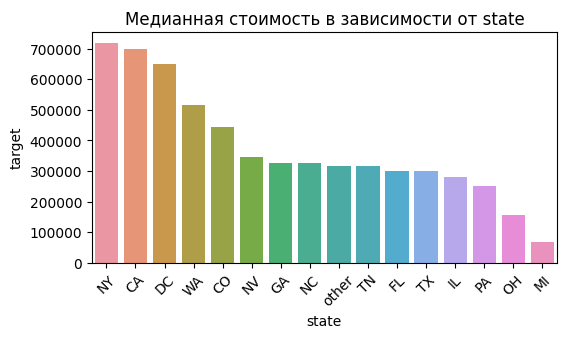

In [44]:
# Распределение признака в зависимости от медианной стоимости
subplots(df,'state')

Как видно из графика стоимость недвижимости зависит от штата.

## city - город

In [45]:
# Переведем названия в нижний регистр, т.к. один и тот же город может быть записан большими и маленькими буквами
df['city'] = df['city'].str.lower() 

# Наиболее часто встречающиеся города оставим как есть, остальные сгруппируем в 'other'
city = df['city'].value_counts()[:30].index
df['city'] = df['city'].apply(lambda x: x if x in city else 'other')

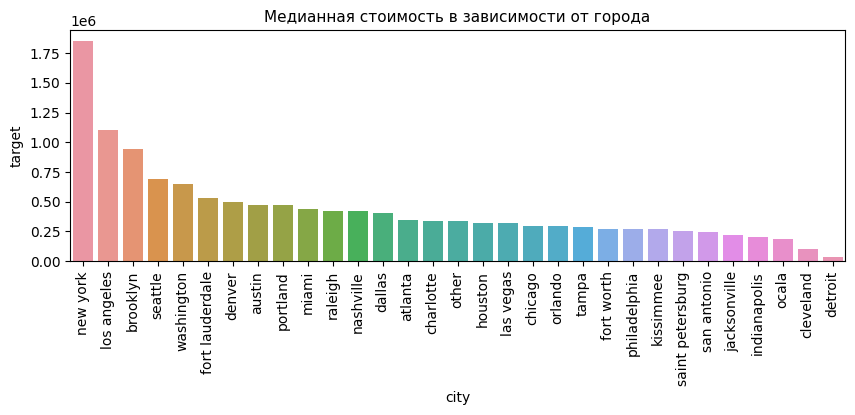

In [46]:
# Медианная стоимость в зависимости от города
city_gr = df.groupby('city')['target'].median().sort_values(ascending=False) 

fig, ax = plt.subplots(figsize=(10, 3))
sns.barplot(x=city_gr.index, y=city_gr.values)
plt.title('Медианная стоимость в зависимости от города', size= 11)
ax.xaxis.set_tick_params(rotation=90)
plt.ylabel('target');

Как видно из графика стоимость недвижимости зависит от города.

## stories - этажность

In [47]:
df['stories'] = df['stories'].astype(str)

def extract_numbers(arg):
    if arg.startswith('One'):
        return '1'
    elif arg.startswith('Two'):
        return '2'
    elif arg.startswith('Three') or arg.startswith('Tri'):
        return '3'
    else:
        return arg
    
df['stories'] = df['stories'].apply(extract_numbers)

df['stories'] = df['stories'].str.extract(r'(\d{1,3})')  

stories = df['stories'].value_counts()[:20].index
df['stories'] = df['stories'].apply(lambda x: x if x in stories else 'other')

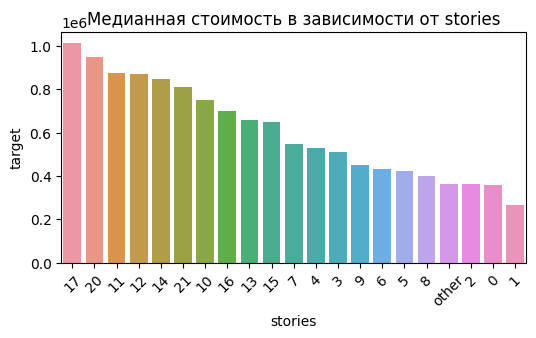

In [48]:
# Распределение признака в зависимости от медианной стоимости
subplots(df,'stories')

Как видно из графика стоимость недвижимости может не зависить от этажности, т.к. нет четкой зависимости того, что чем выше или ниже этаж, тем больше или меньше стоимость.

## zipcode - почтовый индекс

In [49]:
# Оставим только те строки, где есть zipcode и он состоит из пяти цифр
df = df[(df['zipcode'] != '--') & (df['zipcode'] != '0') & (df['zipcode'] != '00000')]
df.loc[:, 'zipcode'] = df['zipcode'].apply(lambda x: x[:5])
# Если zipcode четырехзначный, то добавим 0 в начало строки
df.loc[:, 'zipcode'] = df['zipcode'].apply(lambda x: x.zfill(5) if len(x) == 4 else x)

## street - улица

In [50]:
df['street'] = df['street'].str.lower().str.replace('.', '')

def street_type(arg: str) -> str:
    """Функция преобразования и создания признака «street_type».
        Объединяем улицы в группы в зависимости от их типа

    Args:
        arg (str): Строка из признака «street»

    Returns:
        str: Наименование группы в зависимости от типа улицы
    """
    if ' st' in str(arg) or ' st ' in str(arg) or ' street' in str(arg) or ' street ' in str(arg):
        arg = 'Street'
    elif ' ave' in str(arg) or ' ave ' in str(arg) or ' avenue' in str(arg) or ' avenue ' in str(arg):
        arg = 'Avenue'
    elif ' blvd' in str(arg) or ' blvd ' in str(arg) or ' boulevard' in str(arg) or ' boulevard ' in str(arg):
        arg = 'Boulevard'
    elif ' rd' in str(arg) or ' rd ' in str(arg) or ' road' in str(arg) or ' road ' in str(arg):
        arg = 'Road' 
    elif ' ln' in str(arg) or ' ln ' in str(arg) or ' lane' in str(arg) or ' lane ' in str(arg):
        arg = 'Lane' 
    elif ' dr' in str(arg) or ' dr ' in str(arg) or ' drive' in str(arg) or ' drive ' in str(arg):
        arg = 'Drive' 
    elif ' ct' in str(arg) or ' ct ' in str(arg) or ' court' in str(arg) or ' court ' in str(arg):
        arg = 'Court'
    elif ' pl' in str(arg) or ' pl ' in str(arg) or ' place' in str(arg) or ' place ' in str(arg):
        arg = 'Place'
    elif ' ter' in str(arg) or ' ter ' in str(arg) or ' terrace' in str(arg) or ' terrace ' in str(arg):
        arg = 'Terrace'
    elif ' way' in str(arg) or ' way ' in str(arg):
        arg = 'Way'
    elif ' cir' in str(arg) or ' cir ' in str(arg) or ' circle' in str(arg) or ' circle ' in str(arg):
        arg = 'Circle'
    elif ' pkwy' in str(arg) or ' pkwy ' in str(arg) or ' parkway' in str(arg) or ' parkway ' in str(arg):
        arg = 'Parkway'
    elif ' hwy' in str(arg) or ' hwy ' in str(arg) or ' highway' in str(arg) or ' highway ' in str(arg):
        arg = 'Highway'
    elif ' ln' in str(arg) or ' ln ' in str(arg) or ' lane' in str(arg) or ' lane ' in str(arg):
        arg = 'Lane'
    elif ' sq' in str(arg) or ' sq ' in str(arg) or ' square' in str(arg) or ' square ' in str(arg):
        arg = 'Square'
    elif ' trail' in str(arg) or ' trail ' in str(arg):
        arg = 'Trail'
    elif ' loop' in str(arg) or ' loop ' in str(arg):
        arg = 'Loop'    
    else:
        arg = 'other'
       
    return arg

df['street_type'] = df['street'].apply(street_type)

# Удаление использованных признаков
df.drop('street', axis=1, inplace=True)

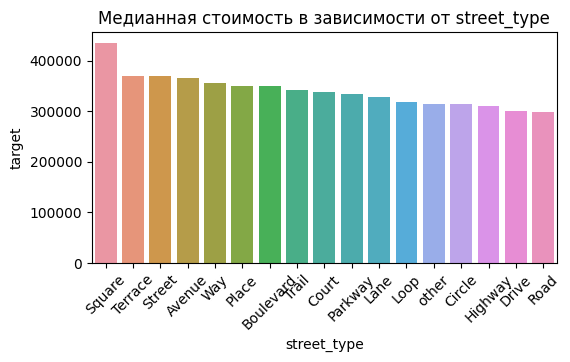

In [51]:
# Распределение признака в зависимости от медианной стоимости
subplots(df,'street_type')

Как видно из графика стоимость недвижимости не сильно зависит от типа улицы. Выделяется только 'Square', но количество данных этого типа низкое и на метрику это мало повлияет.

## beds - спальни

In [52]:
def extract_integer(arg: str) -> int:
    """Функция преобразования признака «beds».
        Извлекаем целые числа из строки

    Args:
        arg (str): Строка из признака «beds»

    Returns:
        int: Количество спален
    """
    if pd.isna(arg):
        return -1  
    elif arg.endswith('sqft') or arg.endswith('acres') or not arg[0].isdigit():
        return -1  
    elif '.0' in str(arg):
        return int(str(arg).replace('.0', ''))
    else:
        return int(''.join(filter(str.isdigit, arg)))

df['beds'] = df['beds'].apply(extract_integer)

## baths - ванные комнаты

In [53]:
def baths(arg: str) -> float:
    """Функция преобразования признака «baths».
        Извлекаем числа с плавающей точкой

    Args:
        arg (str): Строка из признака «baths»

    Returns:
        float: Количество ванных комнат
    """
    # Заменяем запятую на точку и удаляем все символы, кроме цифр, точек и дефисов
    arg = str(arg).replace(',', '.')
    arg = ''.join(filter(lambda x: x.isdigit() or x in ['.', '-', '/'], arg)) # после этого пропуски NaN станут пустой строкой ''
    
    if '/' in arg or '-' in arg: 
        return -1
    # Если строка содержит только пустую строку или только точки
    elif all(char == '' for char in arg) or all(char == '.' for char in arg):
        return -1
    else:
        return float(arg)
    
df['baths'] = df['baths'].apply(baths)

df = df[df.baths < 100]

## fireplace - камин

In [54]:
df['fireplace'] = df['fireplace'].str.lower()

def fireplace(arg: str) -> str:
    """Функция преобразования признака «fireplace».
        Объединяем в группы по наличию камина

    Args:
        arg (str): Строка из признака «fireplace»

    Returns:
        str: Наличие камина
    """
    if 'no' in str(arg) or '0' in str(arg): 
        arg = 'no'
    elif pd.isna(arg):
        arg = 'no_data'     
    else:
        arg = 'yes'
       
    return arg

df['fireplace'] = df['fireplace'].apply(fireplace)

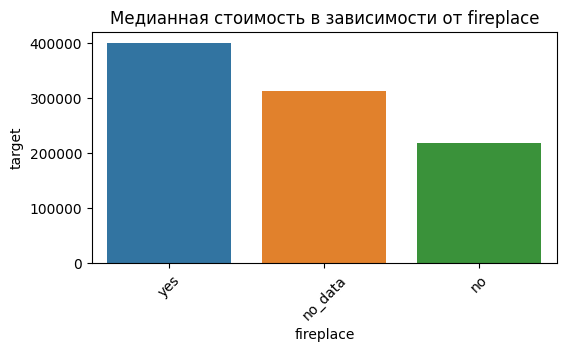

In [55]:
# Распределение признака в зависимости от медианной стоимости
subplots(df,'fireplace')

Как видно из графика стоимость недвижимости зависит от наличия камина.

### Удаление дубликатов

In [56]:
print(f'Число найденных дубликатов: {df[df.duplicated()].shape[0]}')
df = df.drop_duplicates()
print(f'Кол-во оставшихся строк: {df.shape[0]}')

Число найденных дубликатов: 3619
Кол-во оставшихся строк: 295424


Проверим количество пропусков.

In [21]:
df.isnull().sum()

status                  0
propertyType            0
baths                   0
fireplace               0
city                    0
zipcode                 0
beds                    0
state                   0
stories                 0
target                  0
sq_m                    0
pool                    0
schools_rating_avg      0
schools_distance_avg    0
mls_id                  0
year_built              0
heating                 0
cooling                 0
remodeled_year          0
lotsize                 0
street_type             0
dtype: int64

## Создадим признак 'price_m' - стоимость за кв. метр
Самую дешевую и самую дорогую стоимость примем за выбросы. После этого признак удалим. 

In [22]:
# определяем стоимость кв. метра
df['price_m'] = df['target'] / df['sq_m']

In [4]:
def Hist_and_Box_Plots(data, column_name):
    """
    Функция для построения гистограммы и коробчадой диаграмы
    для визуализации выбросов

    :param data: Исходный датафрейм
    :param column_name: Имя признака для анализа
    :return: Выводит график
    """

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 3))  
    histplot = sns.histplot(data=data, x=column_name, ax=axes[0])    
    # histplot.xaxis.set_tick_params(rotation=60)
    
    boxplot = sns.boxplot(data=data, x=column_name, ax=axes[1]) 
    histplot.set_title(f'{column_name} Histogram') 
    boxplot.set_title(f'{column_name} Boxplot') 
    
    plt.tight_layout()
    plt.show()

In [5]:
def outliers_iqr_mod(data, feature, left=1.5, right=1.5):
    """
    Функция для нахождения выбросов методом межквартильного размаха 
    (метод Тьюки)

    :param data: Исходный датафрейм
    :param feature: Имя признака для анализа
    :param left, right: Межквартильный размах
    :return: Возвращает датафрейм с выбросами и очищенный датафрейм
    """ 
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x<lower_bound) | (x> upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned

Целевой признак 'target' имеет широкий диапазон и выбросы, поэтому его нужно прологарифмировать.  
После логарифмирования распределения станут больше похоже на нормальные, что повысит качество работы модели.

Для подтверждения ненормальности распределения используем статистический тест 

In [23]:
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'
alpha = 0.05

s, p = stats.normaltest(df.target)
print('p-value =', p)

if p > alpha:
	print(H0)
else:
	print(Ha)

p-value = 0.0
Данные не распределены нормально (мы отвергаем H0)


Логарифмируем целевой признак

In [24]:
df['target_log'] = np.log(df['target']+1)

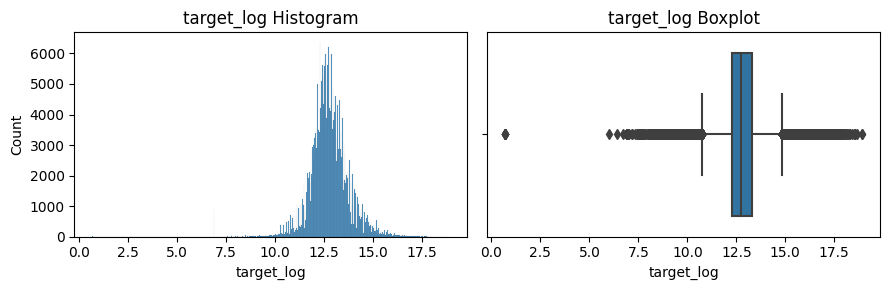

In [11]:
# Визуализируем распределение после логарифмирования
Hist_and_Box_Plots(df,'target_log')  

## Удаление выбросов

### price_m

In [25]:
outliers, df = outliers_iqr_mod(df, 'price_m', left=0.48, right=0.1) 
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {df.shape[0]}')

Число выбросов по методу Тьюки: 76278
Результирующее число записей: 219146


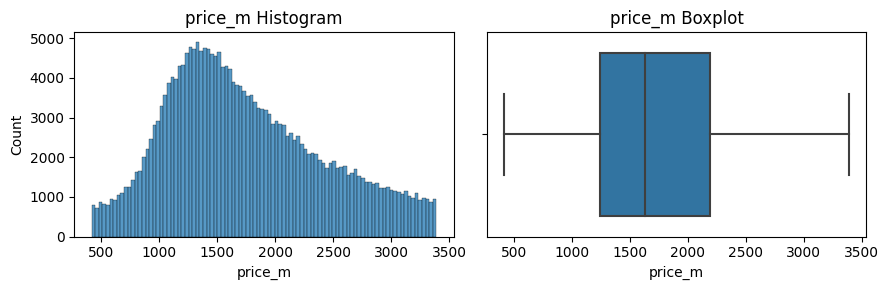

In [64]:
# Визуализируем распределение после очистки от выбросов
Hist_and_Box_Plots(df,'price_m') 

### sq_m

In [26]:
outliers, df = outliers_iqr_mod(df, 'sq_m', left=0.77, right=1.22) 
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {df.shape[0]}')

Число выбросов по методу Тьюки: 12115
Результирующее число записей: 207031


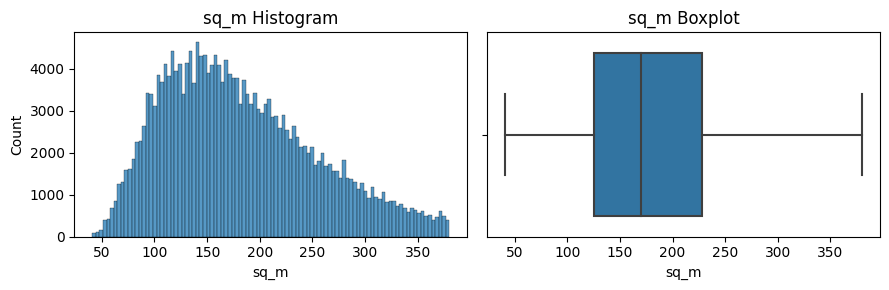

In [68]:
# Визуализируем распределение после очистки от выбросов
Hist_and_Box_Plots(df,'sq_m')

### lotsize

In [27]:
outliers, df = outliers_iqr_mod(df, 'lotsize', left=0.7, right=1.2)
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {df.shape[0]}')

Число выбросов по методу Тьюки: 18455
Результирующее число записей: 188576


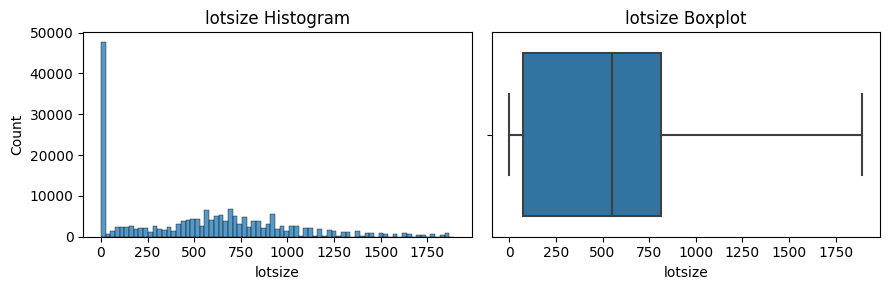

In [72]:
# Визуализируем распределение после очистки от выбросов
Hist_and_Box_Plots(df,'lotsize')

#### Закодируем категориальные признаки
#### Заменяем значения признака на среднюю цену квадратного метра для каждой категории данного признака

In [28]:
# Список признаков, по которым будем вычислять среднюю цену и заменять значения
features = [
    'zipcode', 'state', 'city', 'status', 'propertyType', 'year_built', 
    'remodeled_year', 'stories', 'fireplace', 'heating', 'cooling', 
    'street_type', 'schools_distance_avg'
]  

# Цикл по признакам
for feature in features:
    # Группируем по признаку и вычисляем среднюю цену квадратного метра
    mean_price_m = df.groupby(feature)['price_m'].mean().round(1)
    
    # Заменяем значения признака на среднюю цену квадратного метра
    df[feature] = df[feature].map(mean_price_m)
    
    # Сохраняем результат в CSV файл
    file_name = f'data/mean_price_m_by_{feature}.csv'
    mean_price_m.to_csv(file_name, header=True)

In [29]:
df.drop(['price_m'], axis=1, inplace=True)

#### Статистические тесты
Т.к. распределение данных целевой переменной ненормальное проведем тест Крускала-Уоллиса (для категориальных признаков с  несколькими категориями в признаке) и тест Манна-Уитни (для категориальных признаков с двумя категориями).

In [30]:
# Проведем тест Крускала-Уоллиса (несколько категорий в признаке)
# Категориальные признаки с несколькими категориями
features = [
    'status', 'propertyType', 'baths', 'fireplace', 'city', 
    'zipcode', 'beds', 'state', 'stories', 'year_built', 
    'heating', 'cooling', 'remodeled_year', 'street_type',
    'schools_distance_avg'
    ]

# Гипотезы
H0 = 'Стоимость недвижимости одинаково распределена по всем категориям'
Ha = 'Стоимость недвижимости распределена по-разному хотя бы для одной из категорий'
alpha = 0.05

for feature in features:
    # Формируем группы для теста Крускала-Уоллиса
    groups = [df['target_log'][df[feature] == f] for f in df[feature].unique()]
    
    # Применяем тест Крускала-Уоллиса
    stat, p = stats.kruskal(*groups)
    print(f'Признак: {feature}, p-value: {p}')
    
    # Проверка значимости
    if p > alpha:
        print(f'Не можем отвергнуть нулевую гипотезу: {H0}. "{feature}" возможно не важен.')
    else:
        print(f'Нулевая гипотеза отвергнута: {Ha}. "{feature}" скорее всего важен.')

Признак: status, p-value: 0.0
Нулевая гипотеза отвергнута: Стоимость недвижимости распределена по-разному хотя бы для одной из категорий. "status" скорее всего важен.
Признак: propertyType, p-value: 0.0
Нулевая гипотеза отвергнута: Стоимость недвижимости распределена по-разному хотя бы для одной из категорий. "propertyType" скорее всего важен.
Признак: baths, p-value: 0.0
Нулевая гипотеза отвергнута: Стоимость недвижимости распределена по-разному хотя бы для одной из категорий. "baths" скорее всего важен.
Признак: fireplace, p-value: 0.0
Нулевая гипотеза отвергнута: Стоимость недвижимости распределена по-разному хотя бы для одной из категорий. "fireplace" скорее всего важен.
Признак: city, p-value: 0.0
Нулевая гипотеза отвергнута: Стоимость недвижимости распределена по-разному хотя бы для одной из категорий. "city" скорее всего важен.
Признак: zipcode, p-value: 0.0
Нулевая гипотеза отвергнута: Стоимость недвижимости распределена по-разному хотя бы для одной из категорий. "zipcode" скор

#### Вывод:
По данным тестов, скорее всего, все перечисленные признаки важны.

In [31]:
# Проведем тест Манна-Уитни (категориальные признаки с двумя категориями)
features_2 = ['pool', 'mls_id']

# Гипотезы
H0 = 'Стоимость недвижимости одинаково распределена по категориям'
Ha = 'Стоимость недвижимости распределена по-разному для хотя бы одной категории'
alpha = 0.05

for feature in features_2:
    # Проведение теста Манна-Уитни с двухсторонней проверкой
    stat, p = stats.mannwhitneyu(df['target_log'][df[feature] == 1], 
                                 df['target_log'][df[feature] == 0], 
                                 alternative='two-sided') # двухсторонний тест (то есть проверка на любые различия между группами)
    print(f'Признак: {feature}, p-value: {p}')
    
    # Проверка значимости результата
    if p > alpha:
        print(f'Не можем отвергнуть нулевую гипотезу: {H0}. "{feature}" возможно не важен.')     
    else:
        print(f'Нулевая гипотеза отвергнута: {Ha}. "{feature}" скорее всего важен.')

Признак: pool, p-value: 0.0
Нулевая гипотеза отвергнута: Стоимость недвижимости распределена по-разному для хотя бы одной категории. "pool" скорее всего важен.
Признак: mls_id, p-value: 2.678262444831656e-103
Нулевая гипотеза отвергнута: Стоимость недвижимости распределена по-разному для хотя бы одной категории. "mls_id" скорее всего важен.


#### Вывод:
По данным тестов, скорее всего, все перечисленные признаки важны.

#### Оцениваем мультиколинеарность и взаимосвязь с целевым признаком

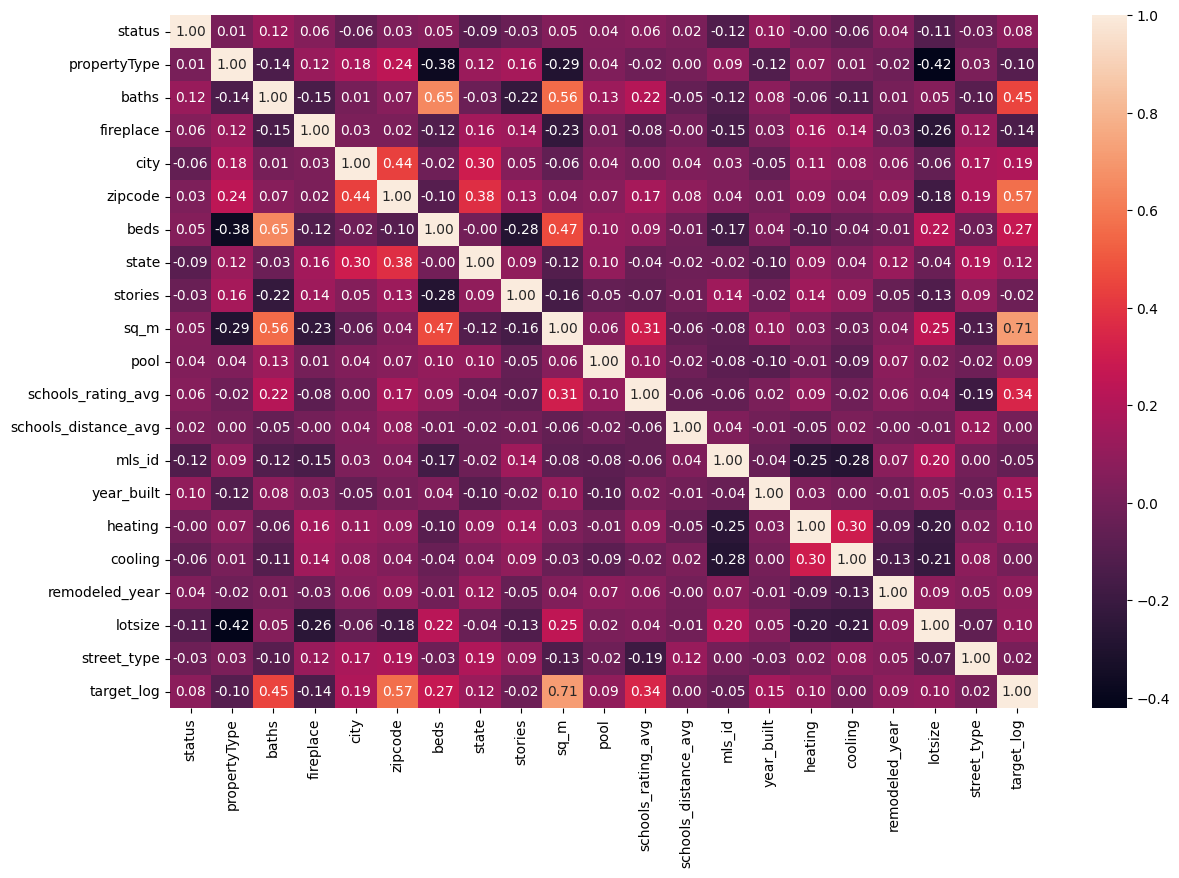

In [32]:
cor = df.copy()
cor.drop(['target'], axis=1, inplace=True)
plt.figure(figsize = (14, 9))
sns.heatmap(cor.corr(method='spearman'), annot = True, fmt='.2f');  

Мультиколинеарность отсутствует. Самая большая корреляция с целевым признаком, как и ожидалось, у площади "sq_m" 0.71. Есть признаки с низкой корреляцией к целевому признаку, но сразу удалять их не будем.  
Т.к. предыдущие статистические тесты показали, что признаки скорее всего важны, то рассмотрим только признаки с корреляцией к целевому признаку менее 0,05.  
Это 'street_type', 'schools_distance_avg', 'cooling', 'stories'.  
После обучения модели на разных комбинациях с признаками, выяснилось, что лучший результат будет, если удалить два признака 'schools_distance_avg' и 'street_type'. Так и сделаем.

In [ ]:
df.drop(['schools_distance_avg', 'street_type'], axis=1, inplace=True)

## 3. Обучение модели и получение предсказания (Model Building):

In [28]:
# Проверим остались ли нечисловые данные
object_columns = [s for s in df.columns
                  if ((df[s].dtypes == 'object') | \
                      (df[s].dtype.name == 'category') | \
                      (df[s].dtypes == 'datetime64[ns]'))]
object_columns

[]

Cформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log.

In [43]:
X = df.drop(['target_log', 'target'], axis=1)  
y_log = df['target_log']
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, random_state = 42, test_size = 0.3)

Стандартизируем данные

In [44]:
scaler = preprocessing.StandardScaler() 
scaler.fit(X_train)
X_train_scal = scaler.transform(X_train)
X_test_scal = scaler.transform(X_test)

In [45]:
print(X_train_scal.shape)
print(X_test_scal.shape)

(132003, 18)
(56573, 18)


In [105]:
# Сохраним scaler в файл. 
with open('data/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

### LinearRegression

In [46]:
#Создаем объект класса LinearRegression
lr = linear_model.LinearRegression()

#Обучаем модель
lr.fit(X_train_scal, y_train_log)

# Оценка качества модели 
y_train_pred = lr.predict(X_train_scal)
y_test_pred = lr.predict(X_test_scal)

# переведем целевую переменную и предсказания модели из логарифмического масштаба в изначальный
y_train_log_exp = np.exp(y_train_log) - 1
y_train_pred_exp = np.exp(y_train_pred) - 1

# переведем целевую переменную и предсказания модели из логарифмического масштаба в изначальный
y_test_log_exp = np.exp(y_test_log) - 1
y_test_pred_exp = np.exp(y_test_pred) - 1

print('MAPE на тренировочном наборе: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_train_log_exp, y_train_pred_exp) * 100))
print('MAPE на тестовом наборе: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_test_log_exp, y_test_pred_exp) * 100))

MAPE на тренировочном наборе: 20.98
MAPE на тестовом наборе: 20.95


### LinearRegression на полиномиальных признаках

#### Степень полинома = 2

In [47]:
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scal)
#Генерируем полиномиальные признаки 
X_train_scal_poly = poly.transform(X_train_scal)
X_test_scal_poly = poly.transform(X_test_scal)

#Выводим результирующие размерности таблиц
print(X_train_scal_poly.shape)
print(X_test_scal_poly.shape)

(132003, 189)
(56573, 189)


In [48]:
#Создаём объект класса LinearRegression
lr_poly = linear_model.LinearRegression()

#Обучаем модель
lr_poly.fit(X_train_scal_poly, y_train_log)

# Оценка качества модели 
y_train_pred = lr_poly.predict(X_train_scal_poly)
y_test_pred = lr_poly.predict(X_test_scal_poly)

# переведем целевую переменную и предсказания модели из логарифмического масштаба в изначальный
y_train_log_exp = np.exp(y_train_log) - 1
y_train_pred_exp = np.exp(y_train_pred) - 1

# переведем целевую переменную и предсказания модели из логарифмического масштаба в изначальный
y_test_log_exp = np.exp(y_test_log) - 1
y_test_pred_exp = np.exp(y_test_pred) - 1

print('MAPE на тренировочном наборе: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_train_log_exp, y_train_pred_exp) * 100))
print('MAPE на тестовом наборе: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_test_log_exp, y_test_pred_exp) * 100))

MAPE на тренировочном наборе: 17.68
MAPE на тестовом наборе: 17.72


Результат улучшился на 3,23 % по сравнению с LinearRegression

### Оптимизация гиперпараметров для RandomForestRegressor с помощью OPTUNA

In [9]:
# Целевая функция
def optuna_rf(trial, cv=5):
        # Пространство гиперпараметров
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 400, step=10),
        'max_depth': trial.suggest_int('max_depth', 5, 20, step=1),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 15, step=1)
        }

    model = RandomForestRegressor(**param, random_state=42)

    # Обучаем модель с помощью кросс-валидации
    score = cross_val_score(model, X_train_scal, y_train_log, cv=cv, scoring="neg_mean_absolute_percentage_error")
        
    return score.mean()

# Создаем объект исследования, минимизируем метрику
study_rf = optuna.create_study(study_name="RandomForestRegressor", direction="minimize")

# Не выводить информационный журнал
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Поиск оптимальных гиперпараметров
study_rf.optimize(optuna_rf, n_trials=20)

print("Наилучшие значения гиперпараметров: {}".format(study_rf.best_params))

[I 2024-10-05 12:44:03,949] A new study created in memory with name: RandomForestRegressor


Наилучшие значения гиперпараметров: {'n_estimators': 130, 'max_depth': 5, 'min_samples_leaf': 7}


In [10]:
# Создаём объект класса RandomForestRegressor
rf = RandomForestRegressor(max_depth=5, n_estimators=130, random_state=42, min_samples_leaf=7)
 
#Обучаем модель
rf.fit(X_train_scal, y_train_log)
  
y_train_pred = rf.predict(X_train_scal)
y_test_pred = rf.predict(X_test_scal)

# переведем целевую переменную и предсказания модели из логарифмического масштаба в изначальный
y_train_log_exp = np.exp(y_train_log) - 1
y_train_pred_exp = np.exp(y_train_pred) - 1

# переведем целевую переменную и предсказания модели из логарифмического масштаба в изначальный
y_test_log_exp = np.exp(y_test_log) - 1
y_test_pred_exp = np.exp(y_test_pred) - 1

print('MAPE на тренировочном наборе: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_train_log_exp, y_train_pred_exp) * 100))
print('MAPE на тестовом наборе: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_test_log_exp, y_test_pred_exp) * 100))

MAPE на тренировочном наборе: 20.66
MAPE на тестовом наборе: 20.73


Результат улучшился всего на 0,35 % по сравнению с LinearRegression, но ухудшился на 3,69% по сравнению с LinearRegression на полиномиальных признаках

### CatBoostRegressor

### Оптимизация гиперпараметров для CatBoostRegressor с помощью OPTUNA

In [108]:
# Целевая функция
def optuna_cb(trial, cv=5): 
    # Пространство гиперпараметров
    param = {
        'depth': trial.suggest_int('depth', 5, 10), 
        'iterations': trial.suggest_int('iterations', 400, 1500, step=100),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 10, 50),
        'bagging_temperature': trial.suggest_int('bagging_temperature', 0, 1)
        }

    model = CatBoostRegressor(**param, random_state=42, verbose=0)

    # Обучаем модель с помощью кросс-валидации
    score = cross_val_score(model, X_train_scal, y_train_log, cv=cv, scoring="neg_mean_absolute_percentage_error")
        
    return score.mean()

# Создаем объект исследования, минимизируем метрику
study_cb = optuna.create_study(study_name="CatBoostRegressor", direction="minimize")

# Не выводить информационный журнал
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Поиск оптимальных гиперпараметров
study_cb.optimize(optuna_cb, n_trials=20)

print("Наилучшие значения гиперпараметров: {}".format(study_cb.best_params))

[I 2024-10-05 02:26:28,470] A new study created in memory with name: CatBoostRegressor


Наилучшие значения гиперпараметров: {'depth': 6, 'iterations': 400, 'l2_leaf_reg': 50, 'bagging_temperature': 1}


In [11]:
# Создаём объект класса CatBoostRegressor
cb = CatBoostRegressor(depth=6, iterations=400, l2_leaf_reg=50, bagging_temperature=1, verbose=False, random_seed=42) 

#Обучаем модель
cb.fit(X_train_scal, y_train_log)   

# Оценка качества модели 
y_train_pred = cb.predict(X_train_scal)
y_test_pred = cb.predict(X_test_scal)

# переведем целевую переменную и предсказания модели из логарифмического масштаба в изначальный
y_train_log_exp = np.exp(y_train_log) - 1
y_train_pred_exp = np.exp(y_train_pred) - 1

# переведем целевую переменную и предсказания модели из логарифмического масштаба в изначальный
y_test_log_exp = np.exp(y_test_log) - 1
y_test_pred_exp = np.exp(y_test_pred) - 1

print('MAPE на тренировочном наборе: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_train_log_exp, y_train_pred_exp) * 100))
print('MAPE на тестовом наборе: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_test_log_exp, y_test_pred_exp) * 100))

MAPE на тренировочном наборе: 16.45
MAPE на тестовом наборе: 16.54


#### Модель CatBoostRegressor показала лучший результат по сравнению с RandomForestRegressor, LinearRegression и LinearRegression на полиномиальных признаках

In [12]:
# Производим сериализацию и записываем результат в файл формата pkl
with open('data/myfile.pkl', 'wb') as output:
    pickle.dump(cb, output)

Визуализируем важность признаков

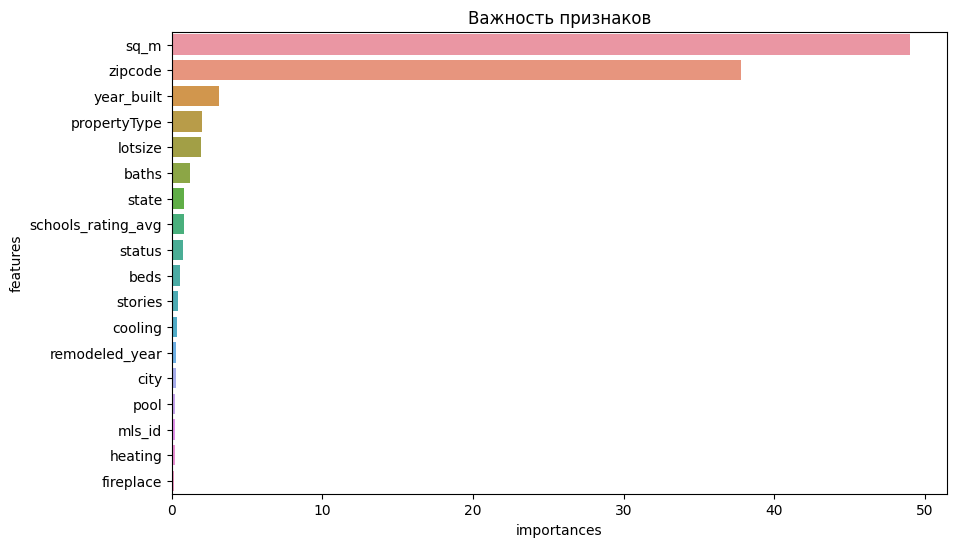

In [13]:
# визуализация важности признаков в порядке убывания
fig, ax = plt.subplots(figsize=(10, 6)) 
features = X.columns
feature_importances = cb.feature_importances_ 
# Создаём DataFrame, содержащий информацию о важности признаков
importances_data = pd.DataFrame({'features': features, 'importances': feature_importances})
importances_data = importances_data.sort_values(by='importances', ascending=False)
# Строим столбчатую диаграмму
sns.barplot(data=importances_data, x='importances', y='features', ax=ax)  
# Добавляем подпись к графику и поворот меток на оси абсцисс
ax.set_title('Важность признаков');
# ax.xaxis.set_tick_params(rotation=90)

In [ ]:
"""
1. Скачать образ с Docker Hub
docker pull eco189/final_project_server_image

2. Запустите контейнер командой:
docker run -d -p=80:80 eco189/final_project_server_image

3. через браузер зайдём по адресу http://localhost

Final_project   
"""